# ECNM10106 Programming for Economics
# Take-Home Exam, Section A

In [1]:
# Importing relevant libraries
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from tabulate import tabulate

from scipy import optimize
from scipy.optimize import fsolve

# Exercise A1. The Life-Cycle of Consumption and Income across Occupational Groups in Uganda.

Use the 2011-2012 Uganda ISA-LSMS data from problem set 2 and answer the following questions. You can find the data and the variables description file in Lab Session 3 in Learn.

In [2]:
# Importing the 2011-2012 Ugandan National Panel Survey data as df_Uganda
df = pd.read_excel('/Users/anniecadanie/Programming for Economics/Week 3/UNPS_1112_PS2.xls')

$a)$ Compute the consumption and income at the per capita level by dividing the household consumption and income by the number of members in the household. Report the mean and the Gini index of consumption and income at the household level and at the per capita level. Is inequality larger measured at the household level or at the per capita level? Why?

In [3]:
# Generating variables for consumption and income per capita

df['consumption_pc'] = df['consumption']/df['familysize']
df['income_pc'] = df['income']/df['familysize']

no_family_size = df['familysize'].isna().sum()
observations = df['familysize'].count()

print(f'''
{no_family_size} households did not report their family size, which means that 16 per capita observations will be 
nans. We will thus create a new dataframe without those households such that the per capita means reflect the
households that have reported their family size. Since the households that have not reported their family size
seems to be random, dropping their observations should not cause bias in our results. Additionally, there remain
{observations} observations, so the results will be quite similar regardless of including versus dropping.
''')

df_pc = df[['consumption_pc','income_pc']].dropna()

# Calculating the mean of the consumption and income at the household and per capita levels
means_household = df[['consumption', 'income']].mean()
means_pc = df_pc[['consumption_pc', 'income_pc']].mean()

# Defining Gini function from sources: https://github.com/oliviaguest/gini and 
# http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm

def gini(array):
    array = np.array(array)
    array = array.flatten() 
    if np.amin(array) < 0:
        array += np.amin(array) 
    array += 0.0000001 
    array = np.sort(array) 
    index = np.arange(1,array.shape[0]+1) 
    n = array.shape[0]
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) 

# Calculating the Gini index of the consumption and income at the household and per capita levels
gini_household = df[['consumption','income']].apply(gini)
gini_pc = df_pc[['consumption_pc','income_pc']].apply(gini)

# Creating a df to store and display results
variables_A1a = ['Consumption','Income']
means_household = means_household.tolist()
means_pc = means_pc.tolist()
gini_household = gini_household.tolist()
gini_pc = gini_pc.tolist()

df_A1a = pd.DataFrame(data = means_household, index = variables_A1a) # Converting data to dataframe
df_A1a['Per Capita Means'] = means_pc
df_A1a['Household Gini'] = gini_household
df_A1a['Per Capita Gini'] = gini_pc

print(tabulate(df_A1a, headers=['Variable','Household Mean','Per Capita Mean','Household Gini','Per Capita Gini']))

print(f'''
The mean level of household consumption is {round(means_household[0],3)}, and the mean level of household income is {round(means_household[1],3)}. 
The mean level of per capita consumption is {round(means_pc[0],3)}, and the mean level of per capita income is {round(means_pc[1],3)}.''')

print(f'''
The Gini coefficient is the most widely used summary measure of inequality in the distribution of household income.
It is a measure of the way in which different household groups receive differing shares, more specifically less 
than equal shares, of total household income. The coefficient ranges from 0 to 100, with 0 representing perfect
equality and 1 representing perfect inequality.

The Gini coefficient of household consumption is {round(gini_household[0],3)}, and the Gini coefficient of household income is {round(gini_household[1],3)}. 
The Gini coefficient of per capita consumption is {round(gini_pc[0],3)}, and the Gini coefficient of per capita income is {round(gini_pc[1],3)}.

As such, there is greater inequality in both consumption and income at the per capita level compared to the
household level. This could potentially be attributed to the fact that family size is positively correlated with
both consumption and income — a household with more family members will likely consume more than a household with 
fewer family members, and a household with more family members will likely require greater income to support
the family than a household with fewer family members. Thus, at the per capita level, there is likely much
greater variation in consumption and income depending on family size, which is masked at the household level.

In this sense, we can hypothesize that controlling for household size reveals the true extent of inequality in
Uganda. However, it is also important to note that a household with only adults is not equivalent to a household
with a mix of adults and children. Ideally, we hope to compute per capita measures for adults only. As such, the
true measures of consumption and income inequality in Uganda likely lie between the household and per capita Gini
coefficients.''')


16 households did not report their family size, which means that 16 per capita observations will be 
nans. We will thus create a new dataframe without those households such that the per capita means reflect the
households that have reported their family size. Since the households that have not reported their family size
seems to be random, dropping their observations should not cause bias in our results. Additionally, there remain
2597 observations, so the results will be quite similar regardless of including versus dropping.

Variable       Household Mean    Per Capita Mean    Household Gini    Per Capita Gini
-----------  ----------------  -----------------  ----------------  -----------------
Consumption           1803.79            293.298          0.365717           0.408498
Income                1860.08            300.117          0.555572           0.581304

The mean level of household consumption is 1803.793, and the mean level of household income is 1860.076. 
The mean level 

$b)$ Create a categorical variable that describes the main occupation of the household: farmer, entrepreneur, or worker. To do so, consider that a household is “farmer” if agricultural income is more than 50% of the household income, an “entrepreneur” if business income is more than 50% of the household total income, and “worker” if labour income is more than 50% of the household total income. What is the proportion of households in each occupational group in Uganda? And in rural vs urban Uganda? Briefly comment on the results.

In [4]:
# Creating variables calculating the shares of agriculture, business, and labour income
df['ag_incshare'] = df['agriculture_inc']/df['income']
df['business_incshare'] = df['business_inc']/df['income']
df['worker_incshare'] = df['wage_labor']/df['income']

# Creating categorical variable for occupation; default is 'Multiple/Other'
df['Occupation'] = 'Multiple/Other'
df.loc[df['ag_incshare'] >= 0.5, 'Occupation'] = 'Farmer'
df.loc[df['business_incshare'] >= 0.5, 'Occupation'] = 'Entrepreneur'
df.loc[df['worker_incshare'] >= 0.5, 'Occupation'] = 'Worker'

# Checking if our categorical variable seems reasonable via summary statistics
df['Occupation'].describe()

# Calculating the share of farmers, entrepreneurs, and workers in Uganda
farmers_share = df['Occupation'].value_counts(normalize = True)['Farmer']
entrepreneurs_share = df['Occupation'].value_counts(normalize = True)['Entrepreneur']
workers_share = df['Occupation'].value_counts(normalize = True)['Worker']
other_share = df['Occupation'].value_counts(normalize = True)['Multiple/Other']

# Calculating the share of farmers, entrepreneurs, and workers in rural and urban Uganda
df_urban = df.groupby('urban')['Occupation'].value_counts(normalize=True)

# Creating a df to store and display results
variables_A1b = ['Farmer','Entrepreneur','Worker','Multiple/Other']
shares_Uganda = [round(farmers_share,3), round(entrepreneurs_share,3), round(workers_share,3), round(other_share,3)]
shares_Uganda_rural = [round(df_urban[0][0],3), round(df_urban[0][2],3), round(df_urban[0][3],3), round(df_urban[0][1],3)]
shares_Uganda_urban = [round(df_urban[1][3],3), round(df_urban[1][1],3), round(df_urban[1][0],3), round(df_urban[1][2],3)]

df_A1b = pd.DataFrame(data = shares_Uganda, index = variables_A1b) # Converting data to dataframe
df_A1b['Rural Shares'] = shares_Uganda_rural
df_A1b['Urban Shares'] = shares_Uganda_urban

print(tabulate(df_A1b, headers=['Occupation','Uganda', 'Rural Uganda', 'Urban Uganda']))


# What is the proportion of households in each occupational group in Uganda? And in rural vs urban Uganda? 
print(f'''
First, all three columns sum to 1, which indicates that our share calculations are indeed valid. Second, I would 
like to clarify my definition of the occupation of 'Multiple/Other'. 'Multiple/Other' implies that a household 
does not have a dominant occupation (they may work a mix of the three primary occupation categories) or their 
primary occupation is not listed. We will henceforth refer to this category as 'other'.

As seen in the table above, the proportion of households in Uganda that are farmers, entrepreneurs, workers, or
other are {round(farmers_share,3)}, {round(entrepreneurs_share,3)}, {round(workers_share,3)}, and {round(other_share,3)}, respectively.

In rural Uganda, the proportion of households that are farmers, entrepreneurs, workers, or other are {round(df_urban[0][0],3)}, {round(df_urban[0][2],3)}, {round(df_urban[0][3],3)}, and {round(df_urban[0][1],3)}, respectively. 

In urban Uganda, the proportion of households that are farmers, entrepreneurs, workers, or other are {round(df_urban[1][3],3)}, {round(df_urban[1][1],3)}, {round(df_urban[1][0],3)}, and {round(df_urban[1][2],3)}, respectively. 

As expected, the proportion of households in each occupation in Uganda lies in between the proportion of households
in each occupation in rural versus urban Uganda. Rural Uganda is noticeably dominated by households primarily
reliant on agriculture income, while agriculture income makes up the lowest shares of household occupations in
urban Uganda. Household occupations in urban Uganda has a much more evenly spread, with households that are 
'workers' being the dominant occupation, followed by 'entrepreneurs'. This aligns with the common finding in the
literature that rural areas are dominated by agriculture jobs, while more urban areas are dominated by more
service jobs. 

Possible explanations for this divide lie with barriers to labour mobility, such as a lack of infrastructure 
linking urban and rural areas, access to certain jobs in specific locations (for example, it may not be very
lucrative to be a farmer in urban Uganda, and it may be difficult to be an entrepreneur in rural Uganda), 
locational or familial preferences, or moving/job search frictions that make it difficult to move into urban areas
(De Magalhães & Santaeulàlia-Llopis 2018).''')

Occupation        Uganda    Rural Uganda    Urban Uganda
--------------  --------  --------------  --------------
Farmer             0.485           0.559           0.167
Entrepreneur       0.172           0.147           0.281
Worker             0.174           0.138           0.327
Multiple/Other     0.17            0.157           0.225

First, all three columns sum to 1, which indicates that our share calculations are indeed valid. Second, I would 
like to clarify my definition of the occupation of 'Multiple/Other'. 'Multiple/Other' implies that a household 
does not have a dominant occupation (they may work a mix of the three primary occupation categories) or their 
primary occupation is not listed. We will henceforth refer to this category as 'other'.

As seen in the table above, the proportion of households in Uganda that are farmers, entrepreneurs, workers, or
other are 0.485, 0.172, 0.174, and 0.17, respectively.

In rural Uganda, the proportion of households that are farmers,

$c)$ Plot the life-cycle of the log of consumption at the household level across occupational groups. Plot the life-cycle of the log of consumption at the per capita level across occupational groups. How does the life-cycle of consumption across occupations change when consumption is measured at the per capita level?

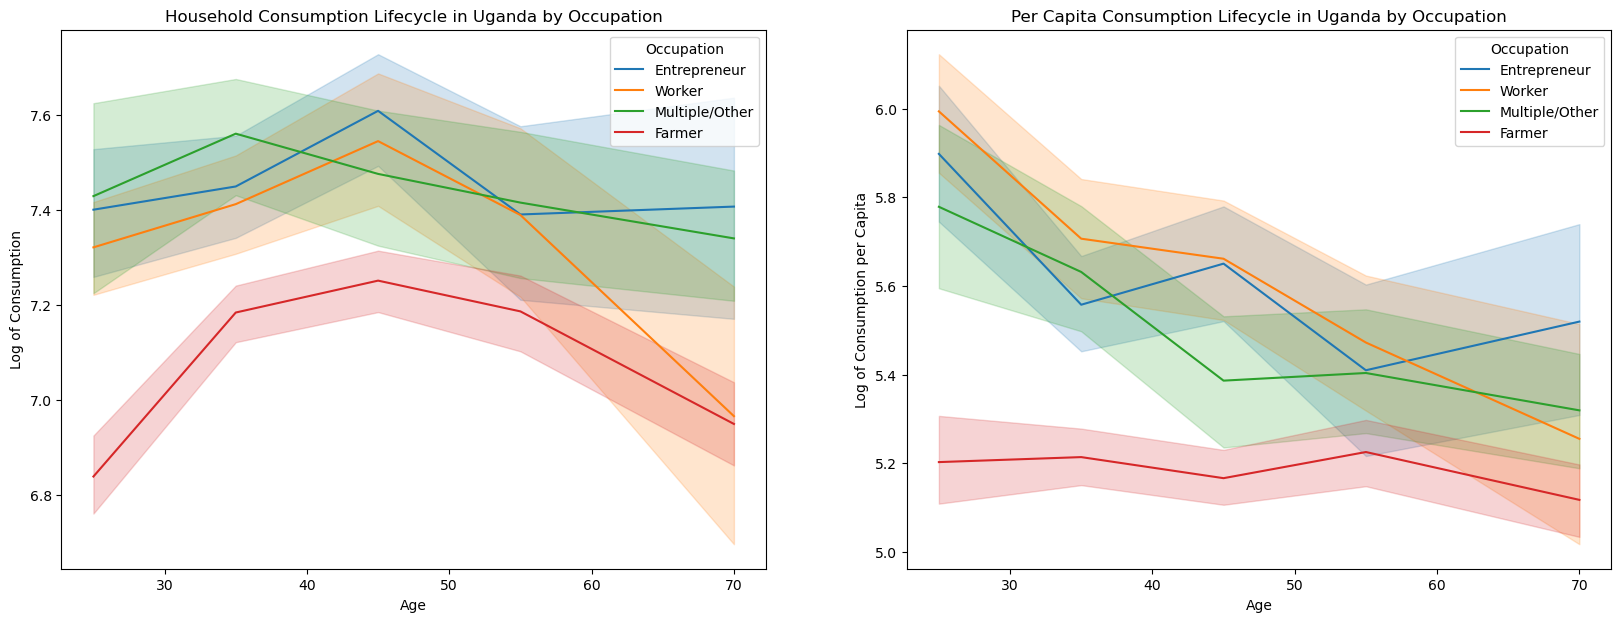


Throughout the lifecycles of both household and per capita consumption, households whose main occupation is farmer
noticeably displays lower consumption at all points compared to the other three occupations.

At the household level, the age profile is concave for all occupational groups, reaching its maximum at around age 
45 for farmer, entrepreneur, and worker and at around 35 for multiple/other. The concavity is most salient for 
farmer and worker, which suggests a greater ability to smooth consumption over the lifecycle for farmer and 
entrepreneur (De Magalhães et al., 2017). Additionally, worker shows an evidence drop in consumption after age 45, 
while log consumption of multiple/other, farmer, and entrepreneur remain more stable over time.

We now turn to the per capita level, as household size likely changes across the age of the household head. We 
observe that controlling for the household size results in significant lifecycle differences. At the per capita 
level, the age 

In [5]:
# Checking the data
df[['consumption','income']].describe()  # 2613 observations, with all positive observations; no further
                                         # transformation required before taking logs

# Creating variables for log of consumption, income, consumption per capita, and income per capita
df[['log_c','log_inc']] = np.log(df[['consumption','income']])
df[['log_c_pc','log_inc_pc']] = np.log(df[['consumption_pc','income_pc']])

# Dropping extreme values (too few observations to get means within age)
df = df[df['head_age'] < 80]
df = df[df['head_age'] > 18]

# Grouping the ages in bins to smooth the line graphs
bins = [18, 30, 40, 50, 60, 80]
labels = [25, 35, 45, 55, 70]
df['age_bins'] = pd.cut(df['head_age'],bins=bins, labels=labels)

# Plot of Household Consumption Lifecycle across Occupational Groups
plt.figure(figsize=(20, 7))

# Consumption Lifecycle across Occupational Groups
plt.subplot(1, 2, 1)
sns.lineplot(x='age_bins',y='log_c', hue='Occupation', data=df)
plt.title('Household Consumption Lifecycle in Uganda by Occupation') # Labelling title and axes
plt.ylabel('Log of Consumption')
plt.xlabel('Age')

# Per Capita Consumption Lifecycle across Occupational Groups
plt.subplot(1, 2, 2)
sns.lineplot(x='age_bins',y='log_c_pc', hue='Occupation', data=df)
plt.title('Per Capita Consumption Lifecycle in Uganda by Occupation') # Labelling title and axes
plt.ylabel('Log of Consumption per Capita')
plt.xlabel('Age')

plt.show()

# How does life-cycle of consumption across occupations change when consumption is measured at the pc level?
print('''
Throughout the lifecycles of both household and per capita consumption, households whose main occupation is farmer
noticeably displays lower consumption at all points compared to the other three occupations.

At the household level, the age profile is concave for all occupational groups, reaching its maximum at around age 
45 for farmer, entrepreneur, and worker and at around 35 for multiple/other. The concavity is most salient for 
farmer and worker, which suggests a greater ability to smooth consumption over the lifecycle for farmer and 
entrepreneur (De Magalhães et al., 2017). Additionally, worker shows an evidence drop in consumption after age 45, 
while log consumption of multiple/other, farmer, and entrepreneur remain more stable over time.

We now turn to the per capita level, as household size likely changes across the age of the household head. We 
observe that controlling for the household size results in significant lifecycle differences. At the per capita 
level, the age profile is falling for all occupational groups, though entrepreneur does show an upward trend after 
the age of 55 and farmer only shows a slight decrease towards the end of the lifecycle. This means that across all 
occupations, the per capita plot suggests that consumption tends to be greater earlier in life. As with
household versus per capita inequality, it is important to note that a household with only adults is not 
equivalent to a household with a mix of adults and children. Older household heads may have more children, while
younger household heads many have less children. If this is true, the per capita measure will naturally show
lower per capita consumption for older household heads, as consumption is divided among children. Again, we
ideally hope to compute per capita measures for adults only, but with this knowledge, it is reasonable to
hypothesize that the true maximum of the life-cycle occurs in between the maximum of the per capita and household
measures.''')

$d)$ Plot the life-cycle of the log of income at the household level across occupational groups. Around what age of the household head does the income of the households attain the maximum? If across some occupations the maximum is different, provide an intuition why.

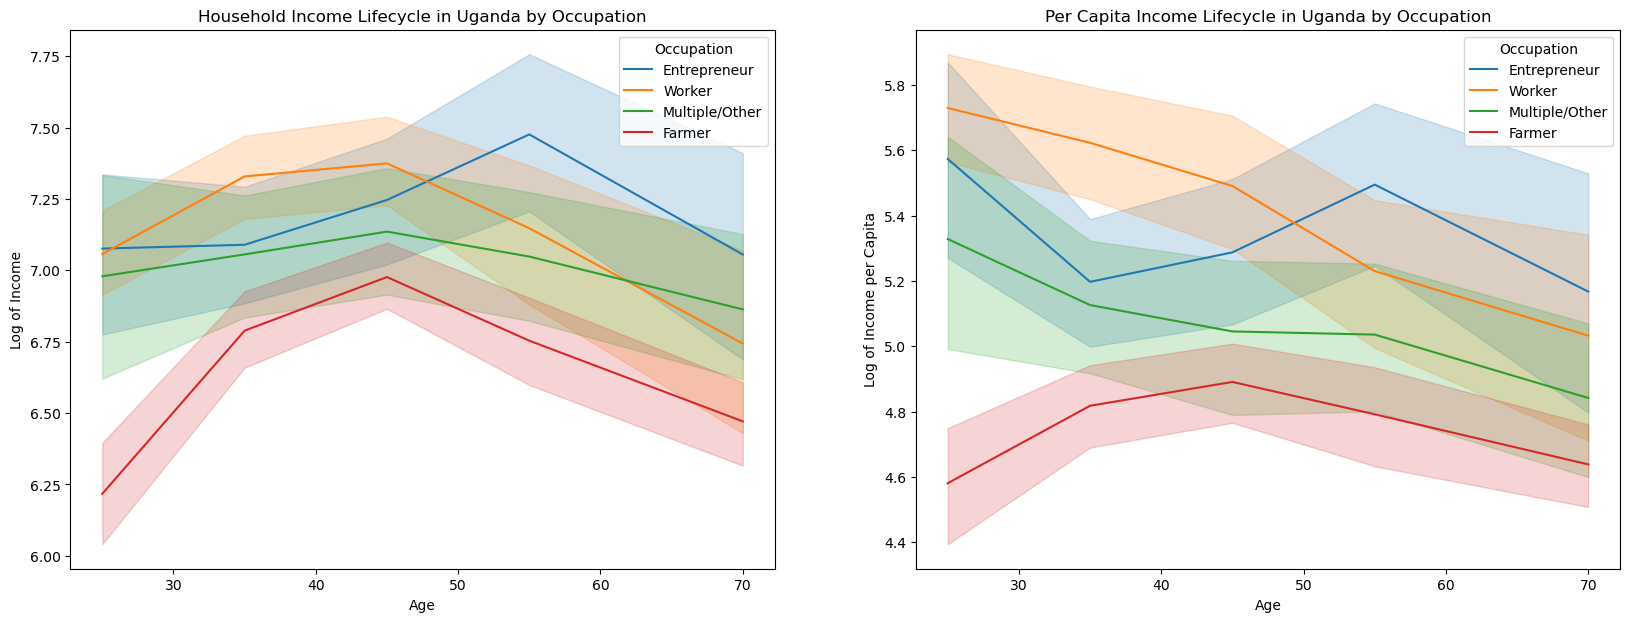


Throughout the lifecycles of both household and per capita income, households whose main occupation is farmer
displays lower consumption at all points compared to the other three occupations, though less noticebly lower
compared to consumption.

At the household level, the age profile is concave for all occupational groups, reaching the maximum at around age 
45 for farmer, other, and worker and at around 55 for entrepreneur. The concavity is most salient for 
farmer. Households whose main occupation is entrepreneur likely achieves the maximum a decade later than the other
three occupations because it takes time to build a business and reap the profits of that business until a later
age, while the other three occupations may see more immediate returns to their labour.

Again, controlling for the household size results in significant lifecycle differences in income for the same
reasons as in (c).


In [6]:
# Household Income Lifecycle across Occupational Groups

plt.figure(figsize=(20, 7))

# Income Lifecycle across Occupational Groups
plt.subplot(1, 2, 1)
sns.lineplot(x='age_bins',y='log_inc', hue='Occupation', data=df)
plt.title('Household Income Lifecycle in Uganda by Occupation') # Labelling title and axes
plt.ylabel('Log of Income')
plt.xlabel('Age')

# Per Capita Income Lifecycle across Occupational Groups
plt.subplot(1, 2, 2)
sns.lineplot(x='age_bins',y='log_inc_pc', hue='Occupation', data=df)
plt.title('Per Capita Income Lifecycle in Uganda by Occupation') # Labelling title and axes
plt.ylabel('Log of Income per Capita')
plt.xlabel('Age')

plt.show()

print('''
Throughout the lifecycles of both household and per capita income, households whose main occupation is farmer
displays lower consumption at all points compared to the other three occupations, though less noticebly lower
compared to consumption.

At the household level, the age profile is concave for all occupational groups, reaching the maximum at around age 
45 for farmer, other, and worker and at around 55 for entrepreneur. The concavity is most salient for 
farmer. Households whose main occupation is entrepreneur likely achieves the maximum a decade later than the other
three occupations because it takes time to build a business and reap the profits of that business until a later
age, while the other three occupations may see more immediate returns to their labour.

Again, controlling for the household size results in significant lifecycle differences in income for the same
reasons as in (c).''')

# Exercise A2. Steady-State and Transitions in a Representative Agent Economy.

Consider an economy populated by a large number of identical infinitely lived households that maximise

\begin{equation*}
\begin{aligned}
    \max_{c_t, i_t}\;\;   &  \sum_{t=0}^{\infty} \beta ^t log(c_t) \\ 
    \text{s.t. } \;\;       &  c_t + i_t = y_t \\     
    \;\; & y_t = Ak_t^\alpha \\
    \;\; & i_t = k_{t+1} - (1-\delta)k_t
\end{aligned}
\end{equation*}

where $c_t$ is consumption, $i_t$ is investment, $k_t$ is the capital stock, and $y_t$ is output. Note that households are choosing consumption and investment at every time period $t$. As is standard, $\beta$ represents the discount rate, $\delta$ represents the depreciation rate of capital, and $A$ is productivity. Take $k_0$ as given.

$a)$ Analytically, solve for the FOC of the problem and find the equilibrium equation of this economy: the Euler equation.

We have an economy populated by a large number of identical infinitely lived households that discount time at the discount factor $\beta$.

The households' three constraints for each time period can be combined into a single per-period budget constraint by plugging the second constraint, the production function, and third constraint, the law of motion of capital, into the first constraint, which states that household expenditure must equal household income. As such, we have the following household per-period budget constraint:
$$c_t + k_{t+1} - (1-\delta)k_t = Ak_t^\alpha $$

The household maximizes its lifetime utility subject to the budget constraint in each period. We can thus write the households' maximization problem as the following Lagrangian:
$$\mathcal{L} = \sum_{t=0}^{\infty} \beta ^t log(c_t) + \sum_{t=0}^{\infty} \lambda_t \Bigl[ Ak_t^\alpha - c_t - k_{t+1} + (1-\delta)k_t \Bigr]$$

where the $\lambda$'s are the Lagrange multipliers on each time period's $t$ budget constraint.

Here, the choice variables are $c_t$ and $k_{t+1}$ for all $t$. Intuitively, the household is trading off consumption and savings intertemporally; consumption today comes at the cost of saving for future accumulation of capital and thus for more consumption in the future. The household's first-order conditions with respect to $c_t$ and $k_{t+1}$ are $\frac {\partial \mathcal{L}}{\partial c_t} = 0$ and $\frac {\partial \mathcal{L}}{\partial k_{t+1}} = 0$. As such, we have the following first-order conditions:

$$\frac {\partial \mathcal{L}}{\partial c_t} = \frac{\beta^t}{c_t} - \lambda_t = 0$$
$$\frac {\partial \mathcal{L}}{\partial k_{t+1}} = -\lambda_t + \lambda_{t+1}\Bigl[\alpha Ak_{t+1}^{\alpha-1} + 1 - \delta \Bigr] = 0$$

Plugging $\lambda_t = \frac{\beta^t}{c_t}$ and $\lambda_{t+1} = \frac{\beta^{t+1}}{c_{t+1}}$ into $\frac {\partial \mathcal{L}}{\partial k_{t+1}}$ yields

$$-\frac{\beta^t}{c_t} + \frac{\beta^{t+1}}{c_{t+1}}\Bigl[\alpha Ak_{t+1}^{\alpha-1} + 1 - \delta \Bigr] = 0$$
$$\frac{\beta^t}{c_t} = \frac{\beta^{t+1}}{c_{t+1}}\Bigl[\alpha Ak_{t+1}^{\alpha-1} + 1 - \delta \Bigr]$$

Simplifying, we obtain the Euler equation, which describes the households' optimal path of consumption over time.
$$\frac{c_{t+1}}{c_t} = \beta\Bigl[\alpha Ak_{t+1}^{\alpha-1} + 1 - \delta \Bigr]$$

In the steady state, capital and output are constant in every period. As such, consumption is also constant in every period such that consumption tomorrow equals consumption today in the steady state. The left hand side of the Euler equation thus simplifies to 1. Due to this long-run equilibrium condition, we can solve for the steady-state levels of capital and output.
$$1 = \beta\Bigl[\alpha Ak^{*\alpha-1} + 1 - \delta \Bigr]$$
$$\frac{1}{\beta} = (\alpha Ak^{*\alpha-1} + 1 - \delta)$$
$$\frac{1}{\beta} - 1 + \delta = \alpha Ak^{*\alpha-1}$$
$$\frac{1 - \beta + \delta \beta}{\beta} = \alpha Ak^{*\alpha-1}$$
$$\frac{1 - \beta + \delta \beta}{\beta \alpha A} = k^{*\alpha-1}$$
$$\frac{1 - \beta + \delta \beta}{\beta \alpha A} = \frac{1}{k^{*1-\alpha}}$$
$$k^{*1-\alpha} = \frac{\beta \alpha A}{1 - \beta + \delta \beta}$$
$$k^* = \Bigl(\frac{\beta \alpha A}{1 - \beta + \delta \beta}\Bigr)^{\frac{1}{1-\alpha}}$$

Plugging $k^*$ into $y$, we also have
$$y^* = Ak^{*\alpha}$$

Finally, plugging $k^*$ and $y^*$ into $c$, we have
$$c^* = y^* - i^*$$
$$c^* = y^* - k^*+(1-\delta)k^*$$
$$c^* = y^* - \delta k^*$$

These equations will be relevant for the following parts.

Use the following parameter values: $\alpha = 0.3$, $\beta = 0.98$, $\delta = 0.07$.

$b)$ Find the value of the TFP parameter, $A$, such that in the economy in steady state, $k^* = k_t = k_{t+1}$, the output level, $y^*$, is equal to 10.

In [7]:
# Defining parameter values

class A2parameters(object):
    def __init__(self, alpha, beta, delta):
        self.alpha = alpha
        self.beta = beta
        self.delta = delta
        
p = A2parameters(0.3, 0.98, 0.07)
params = [p.alpha, p.beta, p.delta]


# Define the system of non-linear equations; this system of equations consists of solving 2 non-linear equations 
# for 2 unknowns: A and steady state capital
def steady_state(X, params):
    
    A, k = X
    alpha, beta, delta = params
    
    y = A*k**alpha # defining y*
    
    # In the steady state, two conditions must hold true:
    # 1) Steady state output is 10, so y - 10 must be equal to 0
    # 2) In the long-run, the Euler equation must be equal to 1.
    
    output_eq = y - 10
    euler_eq = beta * (alpha * A * k**(alpha - 1) + 1 - delta) - 1
    
    return  np.array([output_eq, euler_eq]) # (2,) vector of the values of output_eq and euler_eq


# Solve the system using fsolve
x0 = [5,30] # initial value; note both A and k need to be positive
roots = fsolve(steady_state, x0, args=params)

A_star, k_star = roots # saving values of k* and A
print(f'The value TFP that makes steady state output equal to 10 is A = {round(A_star,3)}.')
print()
print(f'The associated values of steady state capital, output, and consumption are')
y_star = A_star * k_star**p.alpha
c_star = y_star - p.delta*k_star
i_star = k_star - (1-p.delta)*k_star
print(f'k* = {round(k_star,3)}, y* = {round(y_star,3)}, as required, c* = {round(c_star,3)}, and i* = {round(i_star,3)}.')

The value TFP that makes steady state output equal to 10 is A = 3.497.

The associated values of steady state capital, output, and consumption are
k* = 33.183, y* = 10.0, as required, c* = 7.677, and i* = 2.323.


$c)$ Suppose the economy suffers a negative permanent TFP shock and $A$ decreases by 25%. Compute and plot the transition of capital from the original steady state to the new steady state.

In [8]:
# A 25% decrease in A is equivalent to the remaining 0.75 of A.
A_old = A_star
A_new = 0.75*A_old

y_new = A_new * k_star**p.alpha

print(f'''After the permanent negative TFP shock of 25%, the output level immediately falls by the same factor to y* = {round(y_new,3)}.
Additionally, both consumption and investment will instantaneously fall as a reaction to the shock. Due to this 
shock, capital, output, and consumption are above their steady states, so they will all follow the Ramsey model 
predictions and fall over time, eventually converging at their new, lower steady states. Capital does not respond 
instantaneously. Instead, capital falls in the period following the negative TFP shock due to the imeediate fall 
in investment. This decrease in capital further decreases output until a new steady state is reached. As for 
consumption, due to common household preference for consumption smoothing, the household will steadily decrease 
consumption in each subsequent period as well.
''')

print(f'''After the shock, we can solve for the new steady states for capital, output, and consumption using the 
Euler equation, as now we have all relevant parameter values. The new steady state levels are
''')
      
k_star_new = ((p.beta * p.alpha * A_new)/(1 - p.beta + p.delta * p.beta))**(1/(1 - p.alpha))
y_star_new = A_new*k_star_new**(p.alpha)
c_star_new = y_star_new - p.delta*k_star_new
i_star_new = k_star_new - (1-p.delta)*k_star_new

print(f'k* = {round(k_star_new,3)}, y* = {round(y_star_new,3)}, c* = {round(c_star_new,3)}, and i* = {round(i_star_new,3)}.')

print('''
From here, we can solve and plot the transition of output and capital from the original steady state to the new 
steady state. We will assume that the new steady state is achieved in 40 periods and solve a system of 80 
equations based on the equilibrium equation of this economy. In each period, equilibrium is a set of variables
such that the Euler equation and budget constraint are satisfied.''')

After the permanent negative TFP shock of 25%, the output level immediately falls by the same factor to y* = 7.5.
Additionally, both consumption and investment will instantaneously fall as a reaction to the shock. Due to this 
shock, capital, output, and consumption are above their steady states, so they will all follow the Ramsey model 
predictions and fall over time, eventually converging at their new, lower steady states. Capital does not respond 
instantaneously. Instead, capital falls in the period following the negative TFP shock due to the imeediate fall 
in investment. This decrease in capital further decreases output until a new steady state is reached. As for 
consumption, due to common household preference for consumption smoothing, the household will steadily decrease 
consumption in each subsequent period as well.

After the shock, we can solve for the new steady states for capital, output, and consumption using the 
Euler equation, as now we have all relevant parameter va

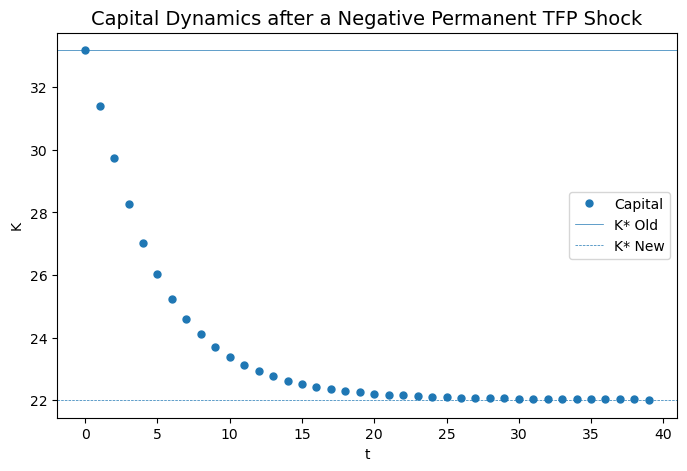


Observing the graph above, we have achieved the desired convergence path from the old level of capital stock
to the new level of capital stock following the permanent negative TFP shock: capital stock indeed shows a 
gradual convergence towards the new steady state of k* = 22.0.


In [11]:
T = 40

def solve_euler_equation():
    
    alpha, beta, delta = params

    # Define the function to be solved for consumption in period 1
    def equilibrium(X): # X is a vector that stores c[0] to c[T-1] and k[0] to k[T-1]; 80 variables for T=40
        
        carray = X[:T]
        karray = X[T:T+T]
        karray[0] = k_star # Capital does not respond instantaneously

        equations = []
        
        for t in range(T-1):
            # Defining the budget constraint and Euler equation for time periods 0-39
            eq_1 = A_new * karray[t]**alpha + (1-delta)*karray[t] - carray[t] - karray[t+1]    
            eq_2 = beta * (alpha * A_new * karray[t+1]**(alpha - 1) + 1 - delta) - carray[t+1]/carray[t]
            equations.append(eq_1)
            equations.append(eq_2)
            
        # Appending final period budget constraint and Euler equation
        equations.append(A_new * karray[39]**alpha + (1-delta)*karray[39] - carray[39] - k_star_new)
        equations.append(beta * (alpha * A_new * k_star_new**(alpha - 1) + 1 - delta) - c_star_new/carray[39])

        return np.array(equations) # Array of system of equations
    

    x0 = [k_star_new]*80

    solutions = fsolve(equilibrium, x0) # Solving system of equations

    # Storing solutions into c_path and k_path
    cpath = np.zeros(T+1)
    kpath = np.zeros(T+1)
    
    cpath[T] = c_star_new
    kpath[0] = k_star
    kpath[T] = k_star_new

    cpath[0:T] = solutions[0:T]
    kpath[1:T] = solutions[T:-1]
        
    return cpath, kpath


cpath, kpath = solve_euler_equation()


# Plot the transition of capital after the shock
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(range(T), kpath[1:], linewidth=2.0,linestyle='None', marker='.', markersize = 10.0,label='Capital')
ax.axhline(k_star, linestyle="solid", linewidth=0.5, label = "K* Old")
ax.axhline(k_star_new, linestyle="dashed", linewidth=0.5, label = "K* New")

ax.set_xlabel('t')
ax.set_ylabel('K')
ax.set_title('Capital Dynamics after a Negative Permanent TFP Shock', fontsize=14)
ax.legend()

plt.show()

print(f'''
Observing the graph above, we have achieved the desired convergence path from the old level of capital stock
to the new level of capital stock following the permanent negative TFP shock: capital stock indeed shows a 
gradual convergence towards the new steady state of k* = {round(k_star_new,3)}.''')

$d)$ Plot the transition of output and consumption along the same period.

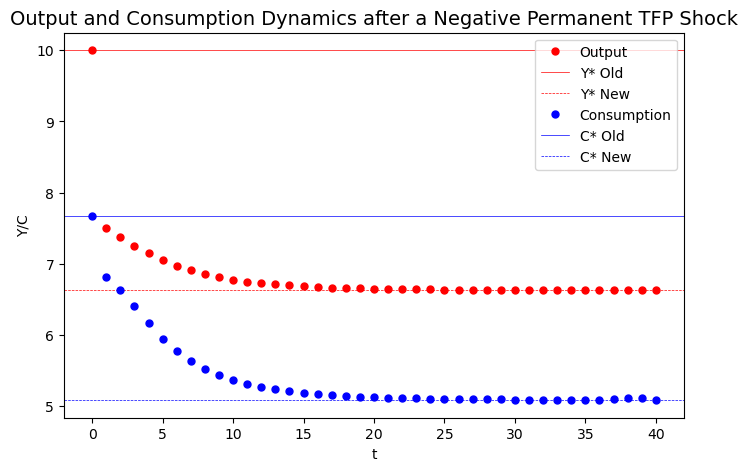


The above convergence dynamics for capital, output, and consumption after the permanent negative TFP shock for 
appear as economic theory would suggest. Output and consumption instantaneously fall as a reaction to the shock
(output indeed falls to the level of 7.5 immediately after the shock), while capital falls in the period after 
the shock (due to decreased investment from the fall in output)and thus displays smoother convergence.

Additionally, in comparing consumption and output, the immediate fall in consumption is less extreme than the
immediate fall in output. This exhibits the household's preference for consumption smoothing over time; the
household would prefer to more slowly decrease their consumption.

Thus, the dynamics of capital, output, and consumption all exhibit downward convergence to the lower steady state
level after the negative TFP shock of 25%.


In [10]:
# Plot the transition of output and consumption after the shock

ypath = A_new * kpath**p.alpha
ypath[0] = y_star
cpath[0] = c_star

fig, ax = plt.subplots(figsize=(8,5))

ax.plot(range(T+1), ypath, linewidth=2.0, color='r',linestyle='None', marker='.', markersize = 10.0,label='Output')
ax.axhline(y_star, color='r', linestyle="solid", linewidth=0.5, label = "Y* Old") # Plotting steady state of output per worker after shock
ax.axhline(y_star_new, color='r', linestyle="dashed", linewidth=0.5, label = "Y* New") # Plotting steady state of output per worker after shock

ax.plot(range(T+1), cpath, linewidth=2.0, color='b',linestyle='None', marker='.', markersize = 10.0,label='Consumption')
ax.axhline(c_star, color='b', linestyle="solid", linewidth=0.5, label = "C* Old") # Plotting steady state of output per worker after shock
ax.axhline(c_star_new, color='b', linestyle="dashed", linewidth=0.5, label = "C* New") # Plotting steady state of output per worker after shock

ax.set_xlabel('t')
ax.set_ylabel('Y/C')
ax.set_title('Output and Consumption Dynamics after a Negative Permanent TFP Shock', fontsize=14)
ax.legend()

plt.show()

print(f'''
The above convergence dynamics for capital, output, and consumption after the permanent negative TFP shock for 
appear as economic theory would suggest. Output and consumption instantaneously fall as a reaction to the shock
(output indeed falls to the level of {round(y_new,3)} immediately after the shock), while capital falls in the period after 
the shock (due to decreased investment from the fall in output)and thus displays smoother convergence.

Additionally, in comparing consumption and output, the immediate fall in consumption is less extreme than the
immediate fall in output. This exhibits the household's preference for consumption smoothing over time; the
household would prefer to more slowly decrease their consumption.

Thus, the dynamics of capital, output, and consumption all exhibit downward convergence to the lower steady state
level after the negative TFP shock of 25%.''')